In [1]:
import glob
import logging
import os
import re
import warnings
from pathlib import Path
from typing import List
from typing import Union

import pandas as pd
from matplotlib import pyplot as plt
from numpy import ndarray
from pandas import DataFrame
from scipy.stats import variation
import numpy as np

In [2]:
DEBUGGING: bool = False

if DEBUGGING:
    logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s',
                        level=logging.DEBUG)
    warnings.filterwarnings("default")
else:
    logging.disable(logging.CRITICAL)
    warnings.filterwarnings("ignore")

In [3]:
plot_sat_name: str = '<sat_name>'
plot_desc_data_name: str = '<data_name>'


def load_json_data(file_path: str) -> pd.DataFrame:
    assert os.path.isfile(file_path), f"File path {file_path} does not exist."
    df = pd.read_json(file_path)
    df.dropna(inplace=True)
    return df


def convert_to_universal_time_format(df: pd.DataFrame, to_period: str = 'M') -> pd.DataFrame:
    time_columns: List[str] = [col for col in df.columns if re.match(r'.*Time.*|.*Obsdate*.|.*time-tag*.', col)]
    df[time_columns] = df[time_columns].apply(pd.to_datetime, errors='coerce')
    df[time_columns] = df[time_columns].apply(lambda col: col.dt.to_period(to_period))
    return df.groupby(time_columns[0]).median().reset_index()


def rename_time_columns_to_universal_format(df: pd.DataFrame) -> pd.DataFrame:
    time_cols: List[str] = [col for col in df.columns if re.match(r'.*Time.*|.*Obsdate*.|.*time-tag*.', col)]
    rename_dict = {col: 'time' if i == 0 else f'time{i}' for i, col in enumerate(time_cols, start=1)}
    return df.rename(columns=rename_dict)


def merge_dataframes_by_time(df1: pd.DataFrame,
                             df2: pd.DataFrame) -> pd.DataFrame:
    # Process time columns in both dataframes
    df1 = rename_time_columns_to_universal_format(df1)
    df2 = rename_time_columns_to_universal_format(df2)

    # Merge dataframes
    merged_df: pd.DataFrame = pd.merge(df1, df2, how='inner')

    return merged_df


def filter_by_years(df: pd.DataFrame, years_to_analyze: List[int]) -> pd.DataFrame:
    time_cols: List[str] = [col for col in df.columns if re.match(r'.*Time.*|.*Obsdate*.|.*time-tag*.', col)]
    return df[df[time_cols[0]].dt.year.isin(years_to_analyze)]


def plot_scatter_single_or_multiple(df: pd.DataFrame, x_col: str, y_cols: List[str]) -> None:
    """
    Plots a scatter plot with one x-column and multiple y-columns.
  
    Args:
        df: The pandas DataFrame containing the data.
        x_col: The name of the column to be used on the x-axis.
        y_cols: A list of column names to be used on the y-axis.
  
    Raises:
        ValueError: If a y-column does not exist in the dataframe.
        TypeError: If a y-column is not numeric.
    """

    for y_col in y_cols:
        if y_col not in df.columns:
            raise ValueError(f"Y column '{y_col}' does not exist in the dataframe.")
        if not pd.api.types.is_numeric_dtype(df[y_col]):
            raise TypeError(f"Y column '{y_col}' is not numeric.")

    # Generate a list of shapes for each y-column
    num_cols = len(y_cols)
    markers: list[str] = ['o', 's', '^', 'P', 'D'] * (num_cols // 5 + 1)  # Repeat cycle of markers
    markers = markers[:num_cols]  # Select only required markers

    plt.figure(figsize=(10, 8))
    for i, y_col in enumerate(y_cols):
        plt.scatter(df[x_col], df[y_col], label=y_col, marker=markers[i])
    plt.title(
        f'{plot_sat_name}: {x_col} aka [{plot_desc_data_name}] vs {"multiple Y-columns" if len(y_cols) > 1 else y_cols[0]}')
    plt.xlabel('Количество аварийных перезагрузок')
    plt.ylabel('Индикаторы солнечной активности')
    plt.legend()  # Adjust x-position for better placement

    plt.subplots_adjust(bottom=0.2)  # Adjust space for legend
    plt.show()


def calculate_correlations_and_plot(df: pd.DataFrame, col_list1: List[str],
                                    col_list2: List[str]) -> None:
    for col1 in col_list1:
        plot_scatter_single_or_multiple(df, col1,
                                        [y for y in col_list2 if y != col1])


def remove_non_numeric_data(df: pd.DataFrame) -> pd.DataFrame:
    # Ignore the first column
    cols_to_drop = []
    for col in df.columns[1:]:
        if df[col].dtype not in ['float64', 'int64']:
            cols_to_drop.append(col)

    return df.drop(cols_to_drop, axis=1)


def preprocess_solar_data(
        solar_data_file: Union[os.PathLike, str]) -> pd.DataFrame:
    df: DataFrame = load_json_data(solar_data_file)
    df = convert_to_universal_time_format(df)
    return df


def preprocess_satellite_data(satellite_data_file: Union[os.PathLike, str],
                              years_to_analyze: List[int]) -> pd.DataFrame:
    df: DataFrame = pd.read_csv(satellite_data_file)
    df = remove_non_numeric_data(df)
    df = convert_to_universal_time_format(df)
    filter_by_years(df, years_to_analyze)
    return df


def process(solar_data_file: Union[os.PathLike, str],
            satellite_data_file: Union[os.PathLike, str],
            years_to_analyze: List[int] = [2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014]) -> None:
    df_solar: DataFrame = preprocess_solar_data(solar_data_file)
    df_satellite: DataFrame = preprocess_satellite_data(satellite_data_file,
                                                        years_to_analyze)
    
    df_solar.rename(columns={
    'ssn': 'Среднее солнечное число',
    'smoothed_ssn': 'Сглаженное среднее солнечное число',
    'observed_swpc_ssn': 'Наблюдаемое SWPC среднее солнечное число',
    'smoothed_swpc_ssn': 'Сглаженное SWPC среднее солнечное число',
    'f10.7': 'Индекс F10.7',
    'smoothed_f10.7': 'Сглаженный индекс F10.7'
    }, inplace=True)


    solar_column_names: List[str] = [col for col in df_solar.columns if
                                     not re.match(
                                         r'.*Time.*|.*Obsdate*.|.*time-tag*.',
                                         col)]
    satellite_column_names: List[str] = [col for col in df_satellite.columns if
                                         not re.match(
                                             r'.*Time.*|.*Obsdate*.|.*time-tag*.',
                                             col)]

    for satellite_column in satellite_column_names:
        column_variation: ndarray = variation(df_satellite[satellite_column])
        if column_variation <= 1e-13:
            logging.warning(
                f"Column '{satellite_column}' is nearly constant, skipping.")
            satellite_column_names.remove(satellite_column)
            df_satellite.drop(satellite_column, axis=1, inplace=True)

    df_solar_satellite_merged: DataFrame = merge_dataframes_by_time(df_solar,
                                                                    df_satellite)
    calculate_correlations_and_plot(df_solar_satellite_merged,
                                    satellite_column_names, solar_column_names)


def analyze_satellite(sat_name: str):
    global plot_sat_name
    plot_sat_name = sat_name

    observed_solar_cycle_data_path: Path = '../data/observed_solar_cycle_indices.json'
    sat_csv_data_files: List[str] = glob.glob(
        os.path.join(f"../data/{sat_name}", "*.csv"))

    if not sat_csv_data_files:
        logging.error(
            f"No CSV files found for satellite=[{sat_name}]. Path checked=[{observed_solar_cycle_data_path}]")
        return

    for sat_file in sat_csv_data_files:
        try:
            assert os.path.exists(
                sat_file), f"File does not exist: [{sat_file}]"
            logging.debug(f"Processing file: [{sat_file}]")

            global plot_desc_data_name
            plot_desc_data_name = os.path.basename(sat_file)
            plot_desc_data_name = re.sub(r'-\d.*$|\.\w+$', '',
                                         plot_desc_data_name,
                                         flags=re.IGNORECASE)
            assert plot_desc_data_name, f"Failed to extract plot description from filename: {sat_file}"

            process(solar_data_file=observed_solar_cycle_data_path,
                    satellite_data_file=os.path.abspath(sat_file))
        except AssertionError as e:
            logging.error(e)
        except Exception as ex:
            logging.exception(
                f"Unexpected error processing file=[{sat_file}] : {ex}")

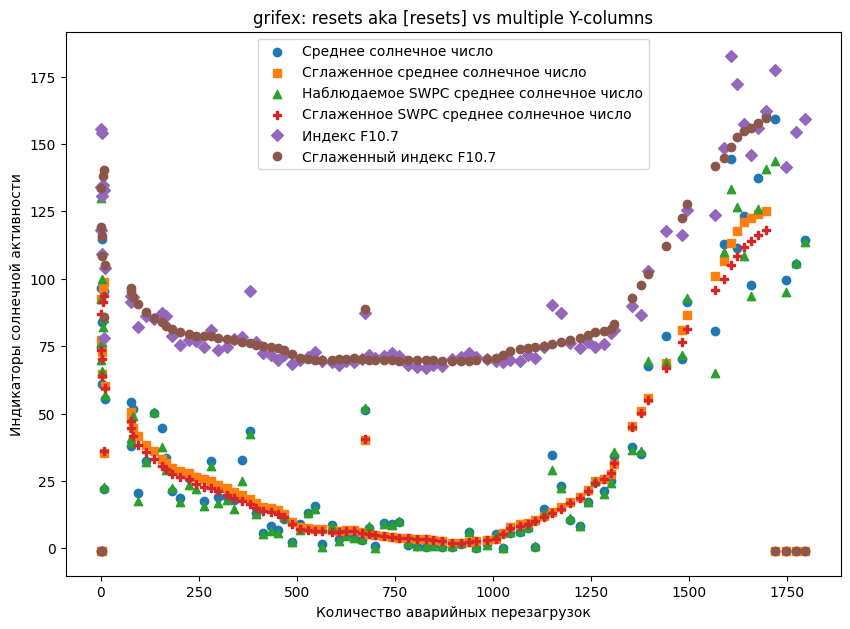

In [4]:
analyze_satellite('grifex')